## Environment Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# hack - https://github.com/googlecolab/colabtools/issues/3409#issuecomment-1446281277
import locale
locale.getpreferredencoding = lambda: "UTF-8"
! pip install -Uq ipdb
import ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.9 MB/s eta 0:00:00


In [3]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
%cd rapidsai-csp-utils
!git checkout 22.12-patch
%cd ..
!python rapidsai-csp-utils/colab/env-check.py
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 390 (delta 89), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (390/390), 107.11 KiB | 6.69 MiB/s, done.
Resolving deltas: 100% (191/191), done.
/content/rapidsai-csp-utils
Branch '22.12-patch' set up to track remote branch '22.12-patch' from 'origin'.
Switched to a new branch '22.12-patch'
/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.7 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/env-check.py", line 26, in <module>
    gpu_name = pynvml.nvmlDeviceGetName(pynvml.nvmlDeviceGetHandleByIndex(0)).decode('UTF-8')
AttributeError: 'str' object has no attribute 'decode'. Did you mean: 'encode'?
Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/pip-install.py", line 26, in <module>
    gpu_name =

In [4]:
%%bash
# Install the Merlin Framework
pip install -Uq git+https://github.com/NVIDIA-Merlin/models.git@release-23.06
pip install -Uq git+https://github.com/NVIDIA-Merlin/nvtabular.git@release-23.06
pip install -Uq git+https://github.com/NVIDIA-Merlin/core.git@release-23.06
# pip install -Uq git+https://github.com/NVIDIA-Merlin/system.git@release-23.04
# pip install -Uq git+https://github.com/NVIDIA-Merlin/dataloader.git@release-23.04
pip install -Uq git+https://github.com/NVIDIA-Merlin/Transformers4Rec.git@release-23.06
# pip install -Uq xgboost lightfm implicit
# tf 2.13 breaks keras
pip install tensorflow==2.12.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.0/122.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.5/985.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Load Data
Reference
- https://github.com/NVIDIA-Merlin/models/blob/main/examples/02-Merlin-Models-and-NVTabular-integration.ipynb

In [5]:
import logging
import warnings

# Set the logging level to a higher value (e.g., CRITICAL)
logging.basicConfig(level=logging.ERROR)

warnings.filterwarnings("ignore")

In [6]:
import os
import shutil
import numpy as np
from nvtabular import ops
from merlin.schema.tags import Tags
import merlin.io
import merlin.models.tf as mm

import nvtabular as nvt

from os import path
import tensorflow as tf


# Get dataframe library - cudf or pandas
from merlin.core.dispatch import get_lib
pd = get_lib()

In [7]:
DATA_DIR = os.environ.get(
    "DATA_DIR", os.path.expanduser("/content/drive/MyDrive/ml-twotower-model/data/")
)
GIT_PROJECT = 'kchopra456/ml-model-template'
USE_REDUCED_TEXTUAL_EMBEDDINGS = False

In [8]:
import glob

USE_AUGMENTED_DATASET= True
DATA_VERSION = 'v4'

_TRAIN,_VALID,_TEST = ('train_aug', 'valid_aug', 'test_aug') if USE_AUGMENTED_DATASET else ('train', 'valid', 'test')

TRAIN_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _TRAIN + f'_{DATA_VERSION}', "*.parquet")))
VALID_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _VALID + f'_{DATA_VERSION}', "*.parquet")))
TEST_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _TEST + f'_{DATA_VERSION}', "*.parquet")))

TRAIN_PATHS, VALID_PATHS, TEST_PATHS

(['/content/drive/MyDrive/ml-twotower-model/data/train_aug_v4/part_0.parquet'],
 ['/content/drive/MyDrive/ml-twotower-model/data/valid_aug_v4/part_0.parquet'],
 ['/content/drive/MyDrive/ml-twotower-model/data/test_aug_v4/part_0.parquet'])

In [9]:
train = merlin.io.Dataset(
    TRAIN_PATHS, engine="parquet"
)
valid = merlin.io.Dataset(
    VALID_PATHS, engine="parquet"
)
test = merlin.io.Dataset(
    TEST_PATHS, engine="parquet"
)


In [10]:
schema = train.schema.select_by_tag([Tags.ITEM_ID, Tags.USER_ID, Tags.ITEM, Tags.USER])
schema

,name,tags,dtype,is_list,is_ragged,properties.cat_path,properties.freq_threshold,properties.start_index,properties.embedding_sizes.dimension,properties.embedding_sizes.cardinality,properties.max_size,properties.num_buckets,properties.domain.min,properties.domain.max,properties.domain.name,properties.value_count.min,properties.value_count.max
0,movie_id,"(Tags.ID, Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,.//categories/unique.movie_id.parquet,0.0,0.0,102.0,1665.0,0.0,None,0,1664,movie_id,NaN,NaN
1,user_id,"(Tags.ID, Tags.USER, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,.//categories/unique.user_id.parquet,0.0,0.0,74.0,944.0,0.0,None,0,943,user_id,NaN,NaN
2,gender,"(Tags.USER, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,.//categories/unique.gender.parquet,0.0,0.0,16.0,3.0,0.0,None,0,2,gender,NaN,NaN
3,occupation,"(Tags.USER, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,.//categories/unique.occupation.parquet,0.0,0.0,16.0,22.0,0.0,None,0,21,occupation,NaN,NaN
4,genres,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",True,True,.//categories/unique.genres.parquet,0.0,0.0,16.0,20.0,0.0,None,0,19,genres,0.0,NaN
5,synopsis,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,.//categories/unique.synopsis.parquet,0.0,0.0,102.0,1665.0,0.0,None,0,1664,synopsis,NaN,NaN
6,title,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,.//categories/unique.title.parquet,0.0,0.0,102.0,1665.0,0.0,None,0,1664,title,NaN,NaN
7,cast,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",True,True,.//categories/unique.cast.parquet,0.0,0.0,183.0,4760.0,0.0,None,0,4759,cast,0.0,NaN


In [11]:
# missing from load
schema['movie_id'].tags._tags.add(Tags.ITEM_ID)
schema['user_id'].tags._tags.add(Tags.USER_ID)

In [12]:
#sanity check
train.to_ddf().head()

,movie_id,movie_id_raw,user_id,gender,occupation,genres,rating,synopsis,title,cast
0,337,1012,7,2,1,"[2, 1]",1,336,336,"[1383, 1384, 1393, 1392, 1388, 1385]"
1,77,245,109,2,8,"[1, 8, 4, 3]",0,77,77,"[2, 30, 106, 558, 514]"
2,5,294,509,1,10,[2],0,5,5,"[46, 203, 204, 58, 202]"
3,614,948,94,2,1,"[2, 5]",0,619,617,"[2117, 2106, 973, 2114, 2091]"
4,1184,1251,104,2,8,[2],1,1196,1182,"[3545, 3532, 3503, 3520]"


In [13]:
# missing from load
schema['movie_id'].tags._tags.add(Tags.ITEM_ID)
schema['user_id'].tags._tags.add(Tags.USER_ID)

In [14]:
# schema = schema.excluding_by_name(col_names=['cast'])

In [72]:
# select only trainable features and exclude the target
train.schema = schema
valid.schema = schema
test.schema = schema

In [16]:
assert len(schema.select_by_tag(Tags.TARGET).column_names) == 0

## Augment with custom pre-trained embeddings

### Load embeddings

In [17]:
FULL_DATASET = True
embedding_path = f'embeddings_train_index_{DATA_VERSION}.parquet'
movie_id_col_to_use = 'movie_id'
if FULL_DATASET:
    embedding_path = f'embeddings_full_index_{DATA_VERSION}.parquet'
    movie_id_col_to_use = 'movie_id_raw'

# embeddings = pd.read_parquet(os.path.join(DATA_DIR, f'embeddings_train_index_{DATA_VERSION}.parquet'))
embeddings = pd.read_parquet(os.path.join(DATA_DIR, embedding_path))

embeddings.shape

(1664, 3)

In [18]:
# sanity check that movie index "0" is missing
embeddings.sort_values(movie_id_col_to_use).head()

,movie_id_raw,title_embeddings,synopsis_embeddings
41,1,"[-0.1271020621061325, -0.3848617672920227, -0....","[-0.23947608470916748, 0.04749224707484245, 0...."
305,2,"[-0.13687743246555328, -0.20053081214427948, -...","[-0.22074897587299347, 0.022454295307397842, 0..."
72,3,"[-0.01994566060602665, -0.20462116599082947, -...","[0.11733447015285492, 0.0836687907576561, 0.37..."
288,4,"[-0.0068391780368983746, -0.3333335518836975, ...","[-0.07648835331201553, 0.1145646795630455, 0.2..."
679,5,"[-0.3565199673175812, -0.2376198172569275, -0....","[-0.0027327132411301136, -0.1977999061346054, ..."


In [19]:
# can be handled better with dask, but we will use pd
train_df = train.to_ddf().compute()
valid_df = valid.to_ddf().compute()
test_df = test.to_ddf().compute()

#### Synopsis Embeddings
- Synopsis embedding will use label encoded synopsis as lookup index

In [20]:
train_movie_id_synopsis_df = train_df[[movie_id_col_to_use, 'synopsis']].groupby([movie_id_col_to_use, 'synopsis'], as_index=False).count()
movie_id_synopsis_df = train_movie_id_synopsis_df
if FULL_DATASET:
    valid_movie_id_synopsis_df = valid_df[[movie_id_col_to_use, 'synopsis']].groupby([movie_id_col_to_use, 'synopsis'], as_index=False).count()
    test_movie_id_synopsis_df = test_df[[movie_id_col_to_use, 'synopsis']].groupby([movie_id_col_to_use, 'synopsis'], as_index=False).count()

    movie_id_synopsis_df = pd.concat((train_movie_id_synopsis_df, valid_movie_id_synopsis_df, test_movie_id_synopsis_df), axis=0, ignore_index=True).drop_duplicates()

movie_id_synopsis_df.head()

,movie_id_raw,synopsis
0,1,8
1,2,240
2,3,375
3,4,108
4,5,390


In [21]:
idx_synopsis_embeddings_df = pd.merge(movie_id_synopsis_df[[movie_id_col_to_use, 'synopsis']],
                                      embeddings[[movie_id_col_to_use, 'synopsis_embeddings']], on=movie_id_col_to_use).drop(movie_id_col_to_use, axis=1).set_index('synopsis').sort_index()
# sanity check synopsis=0 has no embeddings
idx_synopsis_embeddings_df.head()

,synopsis_embeddings
synopsis,
1,"[-0.4067784249782562, -0.014127916656434536, 0..."
2,"[-0.032858122140169144, 0.09768732637166977, 0..."
3,"[0.04936177283525467, -0.06918485462665558, 0...."
4,"[-0.16613557934761047, -0.041616834700107574, ..."
5,"[-0.06875813752412796, 0.1845909059047699, 0.2..."


In [22]:
# add synopsis=0 embeddings
idx_synopsis_embeddings_df.loc[0, 'synopsis_embeddings'] = np.mean(idx_synopsis_embeddings_df['synopsis_embeddings'])
idx_synopsis_embeddings_df.sort_index(inplace=True)
idx_synopsis_embeddings_df.head()

,synopsis_embeddings
synopsis,
0,"[-0.07655343072853454, 0.04274995435513828, 0...."
1,"[-0.4067784249782562, -0.014127916656434536, 0..."
2,"[-0.032858122140169144, 0.09768732637166977, 0..."
3,"[0.04936177283525467, -0.06918485462665558, 0...."
4,"[-0.16613557934761047, -0.041616834700107574, ..."


In [23]:
synopsis_embeddings = np.stack(idx_synopsis_embeddings_df['synopsis_embeddings'])
#sanity check
assert (synopsis_embeddings[1] == idx_synopsis_embeddings_df.loc[1, 'synopsis_embeddings']).all()

#### Title Embeddings
- Title embedding will use label encoded title as lookup index

In [24]:
train_movie_id_title_df = train_df[[movie_id_col_to_use, 'title']].groupby([movie_id_col_to_use, 'title'], as_index=False).count()
movie_id_title_df = train_movie_id_title_df
if FULL_DATASET:
    valid_movie_id_title_df = valid_df[[movie_id_col_to_use, 'title']].groupby([movie_id_col_to_use, 'title'], as_index=False).count()
    test_movie_id_title_df = test_df[[movie_id_col_to_use, 'title']].groupby([movie_id_col_to_use, 'title'], as_index=False).count()

    movie_id_title_df = pd.concat((train_movie_id_title_df, valid_movie_id_title_df, test_movie_id_title_df), axis=0, ignore_index=True).drop_duplicates()

movie_id_title_df.head()

,movie_id_raw,title
0,1,8
1,2,239
2,3,373
3,4,109
4,5,389


In [25]:
idx_title_embeddings_df = pd.merge(movie_id_title_df[[movie_id_col_to_use, 'title']],
                                      embeddings[[movie_id_col_to_use, 'title_embeddings']], on=movie_id_col_to_use).drop(movie_id_col_to_use, axis=1).set_index('title').sort_index()
# sanity check title=0 has no embeddings
idx_title_embeddings_df.head()

,title_embeddings
title,
1,"[-0.09145651757717133, -0.0811767429113388, -0..."
2,"[-0.043679703027009964, -0.21339358389377594, ..."
3,"[-0.06971988081932068, -0.32740920782089233, -..."
4,"[-0.10080163925886154, -0.14979299902915955, -..."
5,"[0.20293867588043213, -0.21028143167495728, -0..."


In [26]:
# add title=0 embeddings
idx_title_embeddings_df.loc[0, 'title_embeddings'] = np.mean(idx_title_embeddings_df['title_embeddings'])
idx_title_embeddings_df.sort_index(inplace=True)
idx_title_embeddings_df

,title_embeddings
title,
0,"[-0.054924961270514286, -0.1981357344611227, -..."
1,"[-0.09145651757717133, -0.0811767429113388, -0..."
2,"[-0.043679703027009964, -0.21339358389377594, ..."
3,"[-0.06971988081932068, -0.32740920782089233, -..."
4,"[-0.10080163925886154, -0.14979299902915955, -..."
...,...
1660,"[0.04619225487112999, -0.33449605107307434, -0..."
1661,"[-0.16195717453956604, -0.04123103991150856, 0..."
1662,"[0.07549984753131866, -0.18107983469963074, -0..."


In [27]:
title_embeddings = np.stack(idx_title_embeddings_df['title_embeddings'])
#sanity check
assert (title_embeddings[1] == idx_title_embeddings_df.loc[1, 'title_embeddings']).all()

### Autoencoder

In [28]:
from keras.layers import Input, Dense
from keras.models import Model

def build_auto_encoder(textual_embedding_dim, encoded_dim=256):

    # Define the input layer
    input_layer = Input(shape=(textual_embedding_dim,))

    # Define the encoder layers
    encoded = Dense(encoded_dim, activation='relu')(input_layer)

    # Define the decoder layers
    decoded = Dense(textual_embedding_dim, activation='sigmoid')(encoded)

    # # Create the encoder model
    encoder_model = Model(input_layer, encoded)

    # Create the autoencoder model
    return Model(input_layer, decoded), encoder_model

In [29]:
encoded_dim = 256
synopsis_autoencoder, synopsis_encoder = build_auto_encoder(synopsis_embeddings.shape[1], encoded_dim)
synopsis_autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# synopsis_autoencoder.fit(synopsis_embeddings, synopsis_embeddings,
#                         epochs=50,
#                         batch_size=64, verbose=0)

In [30]:
encoded_dim = 64
title_autoencoder, title_encoder = build_auto_encoder(title_embeddings.shape[1], encoded_dim)
title_autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# title_autoencoder.fit(title_embeddings, title_embeddings,
#                         epochs=50,
#                         batch_size=64, verbose=0)

In [31]:
def reduce_embeddings(encoded, textual_embedding):
    input_layer = Input(shape=(textual_embedding.shape[1],))

    # Create a model that only includes the encoder part
    encoder_model = Model(input_layer, encoded)

    # Use the encoder to obtain the reduced-dimensional embeddings
    return encoder_model.predict(textual_embedding)

### Use Custom Embedding

In [32]:
if USE_REDUCED_TEXTUAL_EMBEDDINGS:
    synopsis_autoencoder.fit(synopsis_embeddings, synopsis_embeddings,
                        epochs=50,
                        batch_size=512, verbose=0)

    title_autoencoder.fit(title_embeddings, title_embeddings,
                        epochs=50,
                        batch_size=512, verbose=0)

    synopsis_embeddings = synopsis_encoder.predict(synopsis_embeddings)
    title_embeddings = title_encoder.predict(title_embeddings)

In [33]:
# swap synopsis embedding
schema['synopsis'].properties['embedding_sizes'] = {
    'cardinality': float(synopsis_embeddings.shape[0]),
    'dimension': float(synopsis_embeddings.shape[1])
}

# swap title embdeddings
schema['title'].properties['embedding_sizes'] = {
    'cardinality': float(title_embeddings.shape[0]),
    'dimension': float(title_embeddings.shape[1])
}

# schema

In [73]:
# set schema for train and validation set
train.schema = schema
valid.schema = schema
test.schema = schema

In [35]:
embed_dims = {
    "synopsis": synopsis_embeddings.shape[1],
    "title": title_embeddings.shape[1]
}

embeddings_init={
    "synopsis": mm.TensorInitializer(synopsis_embeddings),
    "title": mm.TensorInitializer(title_embeddings),
}

item_embeddings_block = mm.Embeddings(
    train.schema.select_by_tag(Tags.ITEM),
    infer_embedding_sizes=True,
    embeddings_initializer=embeddings_init,
    trainable={
        'synopsis': False,
        'title': False
        },
    dim=embed_dims,
)

## Build Model
Reference
- https://github.com/NVIDIA-Merlin/models/blob/main/examples/05-Retrieval-Model.ipynb
- https://github.com/NVIDIA-Merlin/models/blob/main/examples/usecases/entertainment-with-pretrained-embeddings.ipynb

### Model definition

In [36]:
# collect model_helper.py
! rm model_helper.py || true
! wget --no-cache https://raw.githubusercontent.com/$GIT_PROJECT/master/model_helper.py #-O model_helper.py

rm: cannot remove 'model_helper.py': No such file or directory
--2023-09-10 00:41:28--  https://raw.githubusercontent.com/kchopra456/ml-model-template/master/model_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11588 (11K) [text/plain]
Saving to: ‘model_helper.py’

model_helper.py     100%[===================>]  11.32K  --.-KB/s    in 0.001s  

2023-09-10 00:41:28 (12.5 MB/s) - ‘model_helper.py’ saved [11588/11588]



In [37]:
from model_helper import topk_metrics_aggregator
from model_helper import build_towers
from model_helper import default_plot_metrics
from model_helper import plot_metrics
from model_helper import merge_model_history
from model_helper import EvaluationCallback


In [38]:
# only define one time
if 'models' not in globals():
    models = dict()
    historys = dict()
    train_evaluation_clbks = dict()
    valid_evaluation_clbks = dict()
else:
    print('[INFO] skip redefining static variables')

### model_v101

In [55]:
VERSION = 'v101'

_tower_dim = {
    'user':[512],
    'item':[1024, 512],
}

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 2 # @param
_validation_freq = 1 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param
_logits_temperature = 1

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 196
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [40]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [56]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2
from tensorflow.keras import regularizers

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block,  # needed to initiate the text embeddings
    regularize=dict(
            dropout=0.05,
            kernel_regularizer=regularizers.l2(1e-5),
            bias_regularizer=regularizers.l2(1e-6),
        ),
    logits_temperature=_logits_temperature
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=25, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=25, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [48]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [57]:
# %pdb on
_epochs = 25
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/25
35/35 [==============================] - 32s 594ms/step - loss: 8.0097 - auc: 0.5504 - recall_at_100: 0.0880 - mrr_at_100: 0.0059 - ndcg_at_100: 0.0197 - map_at_100: 0.0059 - precision_at_100: 8.8048e-04 - recall_at_10: 0.0113 - mrr_at_10: 0.0039 - ndcg_at_10: 0.0056 - map_at_10: 0.0039 - precision_at_10: 0.0011 - regularization_loss: 0.0417 - loss_batch: 7.9130 - val_loss: 7.4533 - val_auc: 0.6051 - val_recall_at_100: 0.1301 - val_mrr_at_100: 0.0087 - val_ndcg_at_100: 0.0290 - val_map_at_100: 0.0087 - val_precision_at_100: 0.0013 - val_recall_at_10: 0.0156 - val_mrr_at_10: 0.0057 - val_ndcg_at_10: 0.0080 - val_map_at_10: 0.0057 - val_precision_at_10: 0.0016 - val_regularization_loss: 0.0480 - val_loss_batch: 6.3039
Epoch 2/25
35/35 [==============================] - 14s 357ms/step - loss: 7.1697 - auc: 0.6984 - recall_at_100: 0.1925 - mrr_at_100: 0.0170 - ndcg_at_100: 0.0471 - map_at_100: 0.0170 - precision_at_100: 0.0019 - recall_at_10: 0.0337 - mrr_at_10: 0.0127 - ndcg_at

69/69 [==============================] - 5s 20ms/step - loss: 2.2753 - auc: 0.4787 - recall_at_100: 0.4818 - mrr_at_100: 0.0425 - ndcg_at_100: 0.1198 - map_at_100: 0.0425 - precision_at_100: 0.0048 - recall_at_10: 0.0971 - mrr_at_10: 0.0308 - ndcg_at_10: 0.0460 - map_at_10: 0.0308 - precision_at_10: 0.0097 - regularization_loss: 9.7507e-04 - loss_batch: 2.2840
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.2753348350524902, 'auc': 0.47874388098716736, 'recall_at_100': 0.48246487975120544, 'mrr_at_100': 0.04301578924059868, 'ndcg_at_100': 0.12036663293838501, 'map_at_100': 0.04301578924059868, 'precision_at_100': 0.004824648145586252, 'recall_at_10': 0.09700578451156616, 'mrr_at_10': 0.03115326724946499, 'ndcg_at_10': 0.04628073796629906, 'map_at_10': 0.03115326724946499, 'precision_at_10': 0.009700577706098557, 'regularization_loss': 0.0009750682511366904, 'loss_batch': 2.6963729858398438, 'coverage': 1.0, 'novelty': 0.03128524981753036}
Candidate set rows: 1387


15/15 [==============================] - 3s 24ms/step - loss: 0.9590 - auc: 0.3765 - recall_at_100: 0.1758 - mrr_at_100: 0.0052 - ndcg_at_100: 0.0327 - map_at_100: 0.0052 - precision_at_100: 0.0018 - recall_at_10: 0.0072 - mrr_at_10: 0.0013 - ndcg_at_10: 0.0026 - map_at_10: 0.0013 - precision_at_10: 7.1546e-04 - regularization_loss: 9.7507e-04 - loss_batch: 1.0104
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9589934945106506, 'auc': 0.37646880745887756, 'recall_at_100': 0.18135616183280945, 'mrr_at_100': 0.005437310319393873, 'ndcg_at_100': 0.033929768949747086, 'map_at_100': 0.005437310319393873, 'precision_at_100': 0.0018135616555809975, 'recall_at_10': 0.006887789350003004, 'mrr_at_10': 0.001319337054155767, 'ndcg_at_10': 0.0025642430409789085, 'map_at_10': 0.001319337054155767, 'precision_at_10': 0.0006887788767926395, 'regularization_loss': 0.0009750682511366904, 'loss_batch': 1.5480133295059204, 'coverage': 1.0, 'novelty': 0.15535420098846786}
35/35 [====

#### analysis

In [51]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v101


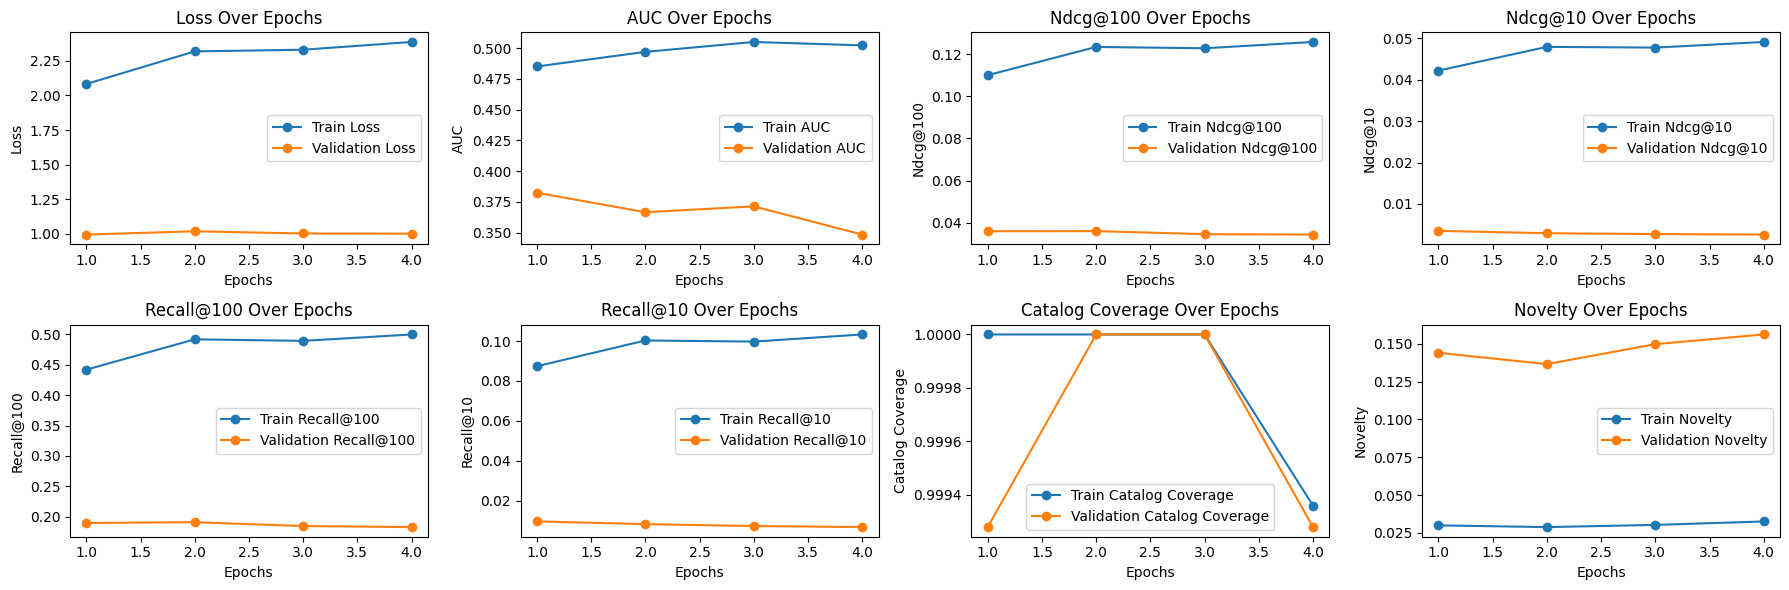

In [52]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Ndcg@10': 'ndcg_at_10',
    'Recall@100': 'recall_at_100',
    'Recall@10': 'recall_at_10',
    # 'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


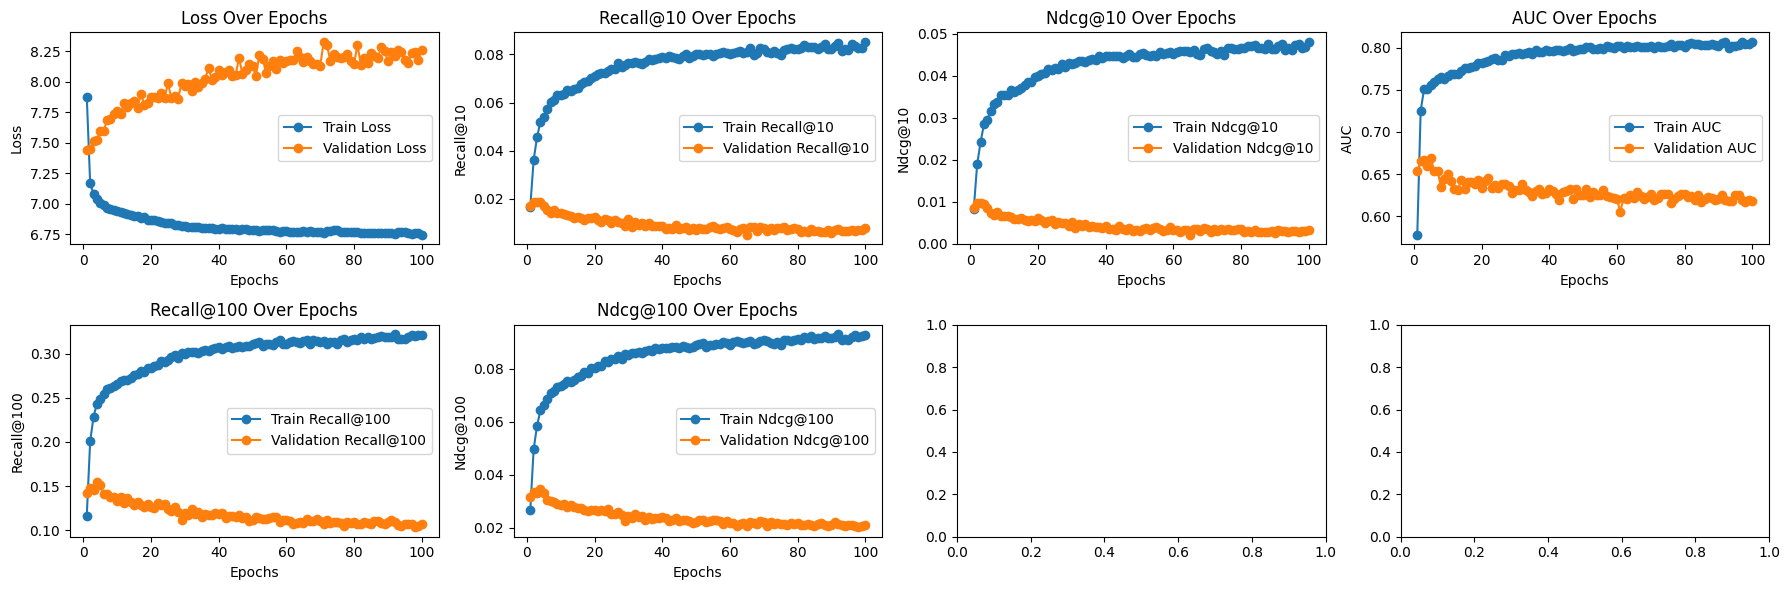

In [53]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

### model_v102

In [ ]:
VERSION = 'v102'

_tower_dim = {
    'user':[512],
    'item':[1024, 512],
}

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 2 # @param
_validation_freq = 1 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param
_logits_temperature = 1

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 196
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [ ]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [ ]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block,  # needed to initiate the text embeddings
    # regularize={},
    logits_temperature=_logits_temperature
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=25, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=25, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 7s 131ms/step - loss: 6.8449 - auc: 0.7854 - recall_at_100: 0.2978 - mrr_at_100: 0.0410 - ndcg_at_100: 0.0864 - map_at_100: 0.0410 - precision_at_100: 0.0030 - recall_at_10: 0.0783 - mrr_at_10: 0.0345 - ndcg_at_10: 0.0446 - map_at_10: 0.0345 - precision_at_10: 0.0078 - regularization_loss: 0.0122 - loss_batch: 6.7585 - val_loss: 7.9970 - val_auc: 0.6141 - val_recall_at_100: 0.1103 - val_mrr_at_100: 0.0056 - val_ndcg_at_100: 0.0228 - val_map_at_100: 0.0056 - val_precision_at_100: 0.0011 - val_recall_at_10: 0.0097 - val_mrr_at_10: 0.0032 - val_ndcg_at_10: 0.0047 - val_map_at_10: 0.0032 - val_precision_at_10: 9.6964e-04 - val_regularization_loss: 0.0130 - val_loss_batch: 7.4399
Epoch 2/50
35/35 [==============================] - 4s 65ms/step - loss: 6.8404 - auc: 0.7870 - recall_at_100: 0.2962 - mrr_at_100: 0.0416 - ndcg_at_100: 0.0868 - map_at_100: 0.0416 - precision_at_100: 0.0030 - recall_at_10: 0.0808 - mrr_at_10: 0.0351 - ndcg_at_10

#### analysis

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v102


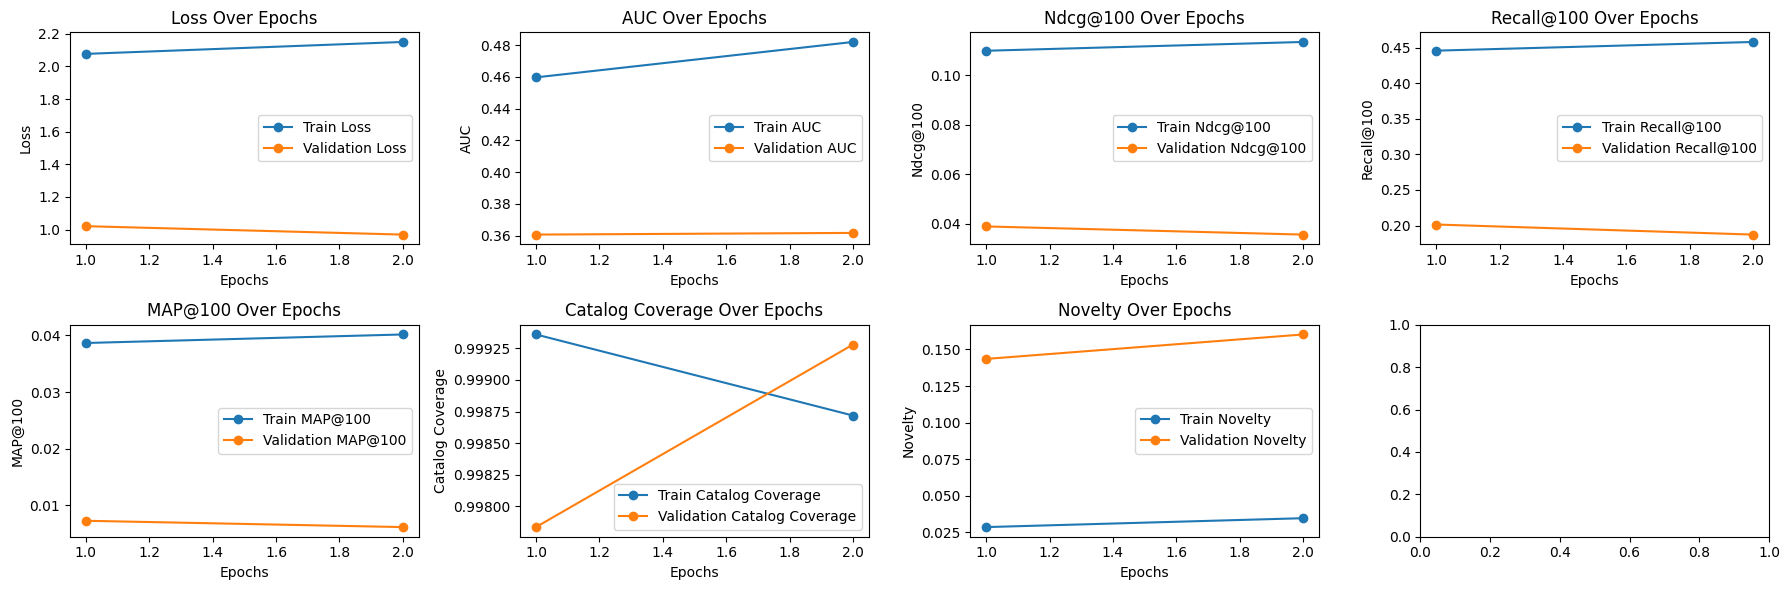

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v102


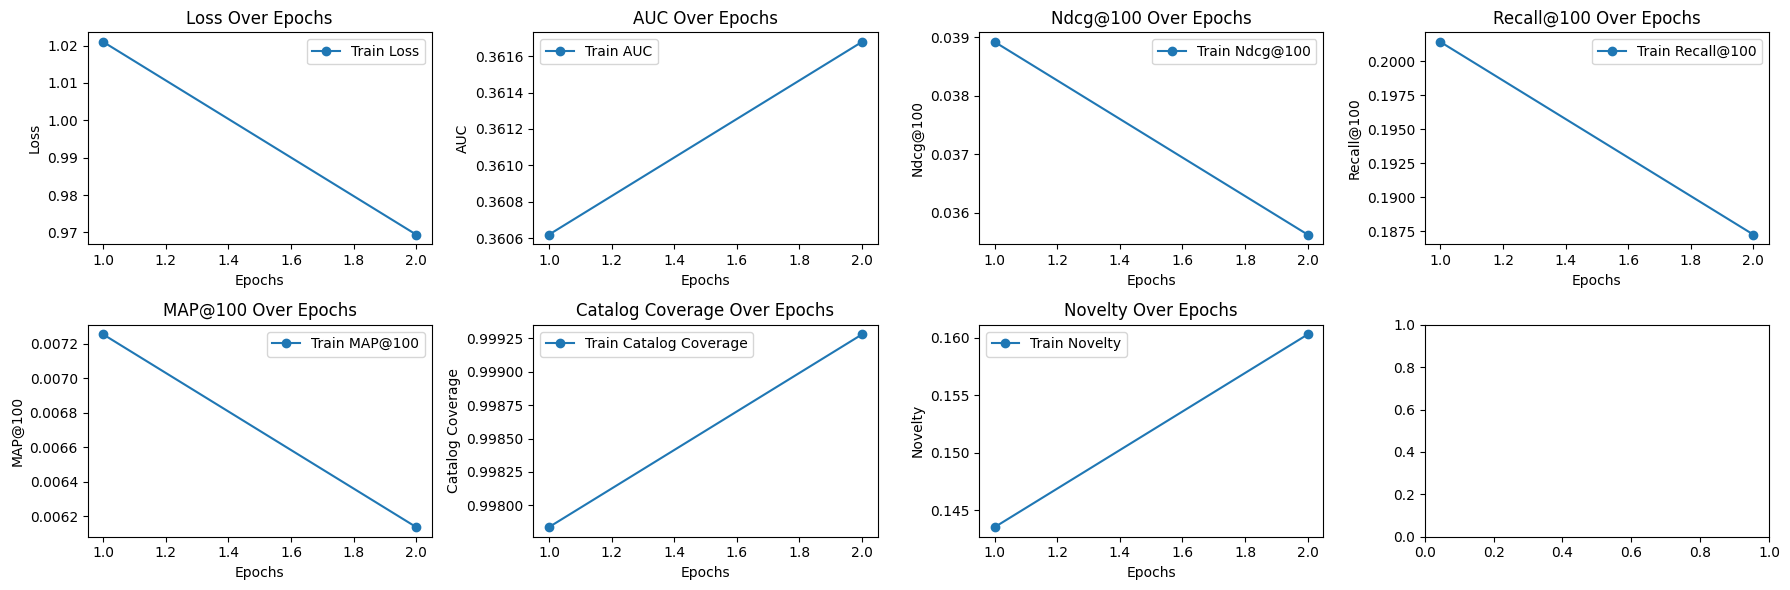

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history_val, None, _metrics)


Plot for model v10


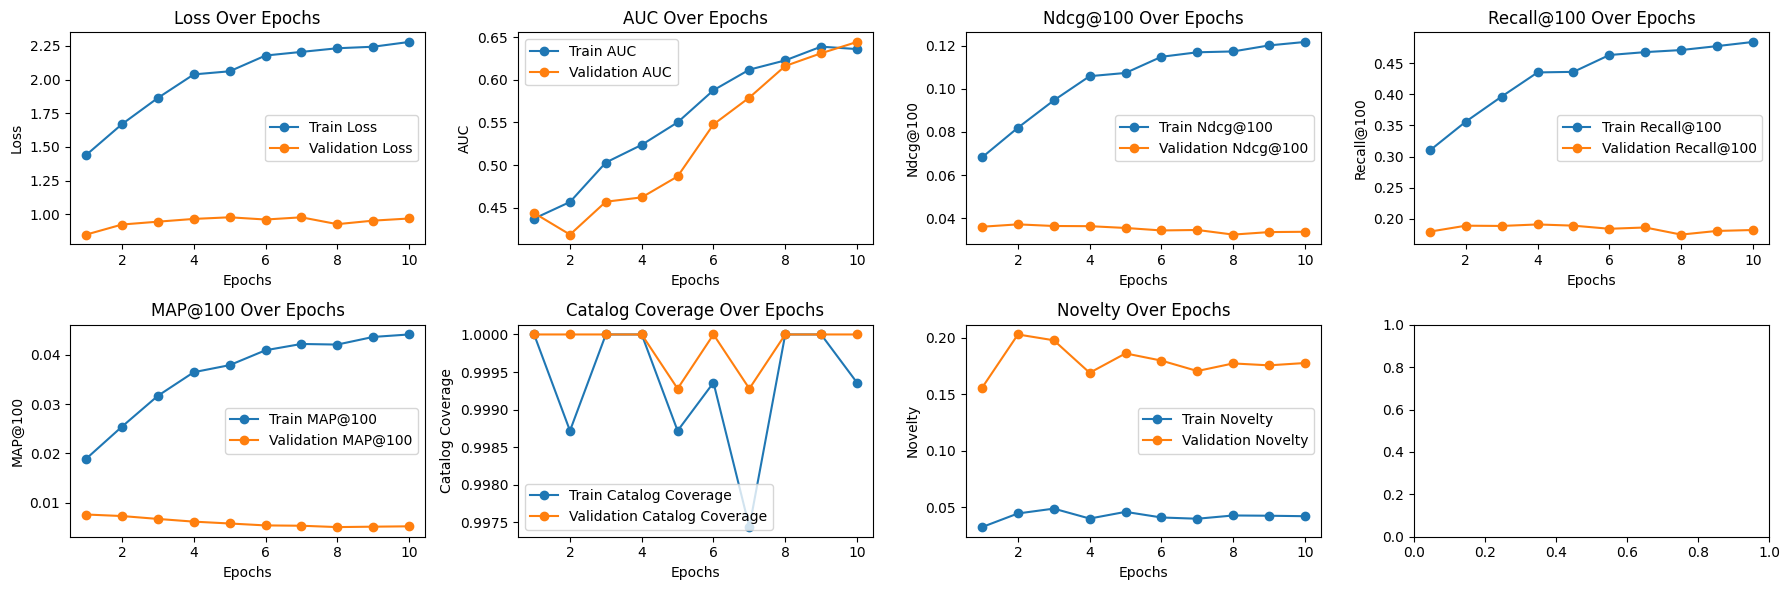

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


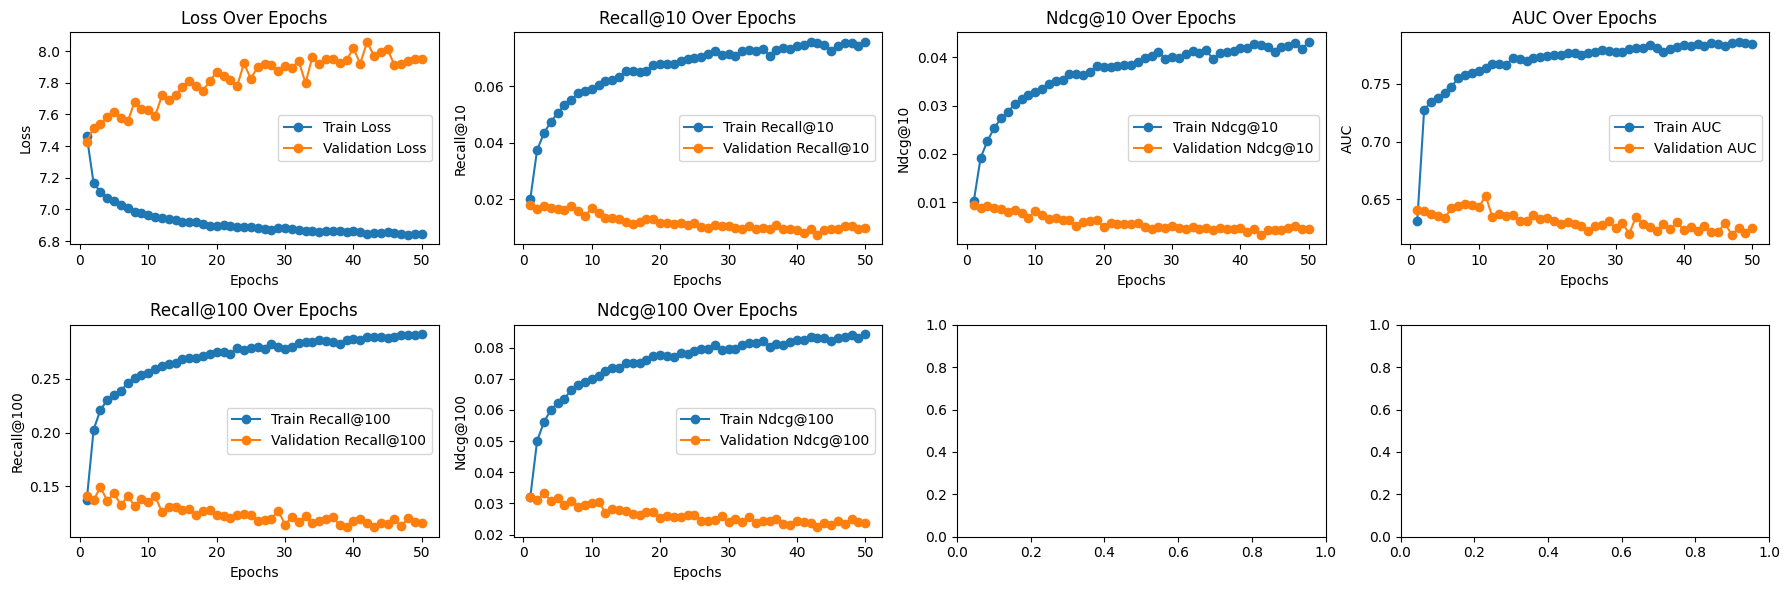

In [ ]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

### model_v103

In [ ]:
VERSION = 'v103'

_tower_dim = {
    'user':[256, 256],
    'item':[256, 256],
}

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size # @param
_validation_freq = 1 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 96
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [ ]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [ ]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block  # needed to initiate the text embeddings
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=10, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=10, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 34s 621ms/step - loss: 7.4966 - auc: 0.6039 - recall_at_100: 0.0819 - mrr_at_100: 0.0056 - ndcg_at_100: 0.0184 - map_at_100: 0.0056 - precision_at_100: 8.1856e-04 - recall_at_50: 0.0438 - mrr_at_50: 0.0050 - ndcg_at_50: 0.0123 - map_at_50: 0.0050 - precision_at_50: 8.7559e-04 - recall_at_10: 0.0106 - mrr_at_10: 0.0037 - ndcg_at_10: 0.0053 - map_at_10: 0.0037 - precision_at_10: 0.0011 - regularization_loss: 0.0000e+00 - loss_batch: 7.4223 - val_loss: 7.3945 - val_auc: 0.6579 - val_recall_at_100: 0.1402 - val_mrr_at_100: 0.0088 - val_ndcg_at_100: 0.0307 - val_map_at_100: 0.0088 - val_precision_at_100: 0.0014 - val_recall_at_50: 0.0725 - val_mrr_at_50: 0.0078 - val_ndcg_at_50: 0.0198 - val_map_at_50: 0.0078 - val_precision_at_50: 0.0014 - val_recall_at_10: 0.0156 - val_mrr_at_10: 0.0056 - val_ndcg_at_10: 0.0079 - val_map_at_10: 0.0056 - val_precision_at_10: 0.0016 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 6.3161
Epoch 2/50


69/69 [==============================] - 7s 21ms/step - loss: 1.7324 - auc: 0.5667 - recall_at_100: 0.3651 - mrr_at_100: 0.0273 - ndcg_at_100: 0.0854 - map_at_100: 0.0273 - precision_at_100: 0.0037 - recall_at_10: 0.0575 - mrr_at_10: 0.0185 - ndcg_at_10: 0.0275 - map_at_10: 0.0185 - precision_at_10: 0.0057 - regularization_loss: 0.0000e+00 - loss_batch: 1.7427
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7323670387268066, 'auc': 0.5666812062263489, 'recall_at_100': 0.36704081296920776, 'mrr_at_100': 0.028207382187247276, 'ndcg_at_100': 0.08657605946063995, 'map_at_100': 0.028207382187247276, 'precision_at_100': 0.0036704079248011112, 'recall_at_10': 0.05967066437005997, 'mrr_at_10': 0.019423503428697586, 'ndcg_at_10': 0.028665069490671158, 'map_at_10': 0.019423503428697586, 'precision_at_10': 0.005967066623270512, 'regularization_loss': 0.0, 'loss_batch': 2.231379985809326, 'coverage': 1.0, 'novelty': 0.04095370450794754}
Candidate set rows: 1387


15/15 [==============================] - 5s 37ms/step - loss: 0.9345 - auc: 0.5850 - recall_at_100: 0.1817 - mrr_at_100: 0.0064 - ndcg_at_100: 0.0351 - map_at_100: 0.0064 - precision_at_100: 0.0018 - recall_at_10: 0.0105 - mrr_at_10: 0.0022 - ndcg_at_10: 0.0041 - map_at_10: 0.0022 - precision_at_10: 0.0011 - regularization_loss: 0.0000e+00 - loss_batch: 0.9830
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9345451593399048, 'auc': 0.5849609375, 'recall_at_100': 0.18757523596286774, 'mrr_at_100': 0.00700428755953908, 'ndcg_at_100': 0.03659487143158913, 'map_at_100': 0.00700428755953908, 'precision_at_100': 0.0018757523503154516, 'recall_at_10': 0.011903169564902782, 'mrr_at_10': 0.0027449256740510464, 'ndcg_at_10': 0.004811782855540514, 'map_at_10': 0.0027449256740510464, 'precision_at_10': 0.0011903168633580208, 'regularization_loss': 0.0, 'loss_batch': 1.4892228841781616, 'coverage': 0.9870223503965393, 'novelty': 0.18814844373503592}
35/35 [====================

69/69 [==============================] - 5s 23ms/step - loss: 1.9925 - auc: 0.5434 - recall_at_100: 0.4212 - mrr_at_100: 0.0337 - ndcg_at_100: 0.1007 - map_at_100: 0.0337 - precision_at_100: 0.0042 - recall_at_10: 0.0724 - mrr_at_10: 0.0236 - ndcg_at_10: 0.0348 - map_at_10: 0.0236 - precision_at_10: 0.0072 - regularization_loss: 0.0000e+00 - loss_batch: 2.0055
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9924883842468262, 'auc': 0.5433974862098694, 'recall_at_100': 0.4218968152999878, 'mrr_at_100': 0.03398360311985016, 'ndcg_at_100': 0.10113386809825897, 'map_at_100': 0.03398360311985016, 'precision_at_100': 0.004218969028443098, 'recall_at_10': 0.07303211092948914, 'mrr_at_10': 0.02387097477912903, 'ndcg_at_10': 0.035155024379491806, 'map_at_10': 0.02387097477912903, 'precision_at_10': 0.007303211838006973, 'regularization_loss': 0.0, 'loss_batch': 2.625227451324463, 'coverage': 1.0, 'novelty': 0.03690802348336595}
Candidate set rows: 1387


15/15 [==============================] - 11s 32ms/step - loss: 0.9431 - auc: 0.5403 - recall_at_100: 0.1828 - mrr_at_100: 0.0060 - ndcg_at_100: 0.0347 - map_at_100: 0.0060 - precision_at_100: 0.0018 - recall_at_10: 0.0093 - mrr_at_10: 0.0020 - ndcg_at_10: 0.0036 - map_at_10: 0.0020 - precision_at_10: 9.3409e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9816
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9431490302085876, 'auc': 0.5402566194534302, 'recall_at_100': 0.1859034299850464, 'mrr_at_100': 0.006577146705240011, 'ndcg_at_100': 0.03575333207845688, 'map_at_100': 0.006577146705240011, 'precision_at_100': 0.0018590344116091728, 'recall_at_10': 0.010298248380422592, 'mrr_at_10': 0.002440446987748146, 'ndcg_at_10': 0.00422116881236434, 'map_at_10': 0.002440446987748146, 'precision_at_10': 0.0010298247216269374, 'regularization_loss': 0.0, 'loss_batch': 1.3837964534759521, 'coverage': 0.9906272530641672, 'novelty': 0.1630359612724758}
35/35 [============

69/69 [==============================] - 6s 31ms/step - loss: 2.0388 - auc: 0.5608 - recall_at_100: 0.4304 - mrr_at_100: 0.0345 - ndcg_at_100: 0.1032 - map_at_100: 0.0345 - precision_at_100: 0.0043 - recall_at_10: 0.0755 - mrr_at_10: 0.0241 - ndcg_at_10: 0.0359 - map_at_10: 0.0241 - precision_at_10: 0.0075 - regularization_loss: 0.0000e+00 - loss_batch: 2.0539
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.0388457775115967, 'auc': 0.5608031749725342, 'recall_at_100': 0.4314122200012207, 'mrr_at_100': 0.03568214178085327, 'ndcg_at_100': 0.1044798344373703, 'map_at_100': 0.03568214178085327, 'precision_at_100': 0.004314121790230274, 'recall_at_10': 0.07753340154886246, 'mrr_at_10': 0.02524939738214016, 'ndcg_at_10': 0.03724619746208191, 'map_at_10': 0.02524939738214016, 'precision_at_10': 0.007753340061753988, 'regularization_loss': 0.0, 'loss_batch': 2.7665252685546875, 'coverage': 1.0, 'novelty': 0.042648455519876984}
Candidate set rows: 1387


15/15 [==============================] - 3s 23ms/step - loss: 0.9687 - auc: 0.5499 - recall_at_100: 0.1844 - mrr_at_100: 0.0061 - ndcg_at_100: 0.0349 - map_at_100: 0.0061 - precision_at_100: 0.0018 - recall_at_10: 0.0086 - mrr_at_10: 0.0020 - ndcg_at_10: 0.0035 - map_at_10: 0.0020 - precision_at_10: 8.6266e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0195
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9686815142631531, 'auc': 0.5499061346054077, 'recall_at_100': 0.18871204555034637, 'mrr_at_100': 0.0061890678480267525, 'ndcg_at_100': 0.03576025739312172, 'map_at_100': 0.0061890678480267525, 'precision_at_100': 0.0018871204229071736, 'recall_at_10': 0.008492711000144482, 'mrr_at_10': 0.0019665067084133625, 'ndcg_at_10': 0.003430602140724659, 'map_at_10': 0.0019665067084133625, 'precision_at_10': 0.0008492710767313838, 'regularization_loss': 0.0, 'loss_batch': 1.551398754119873, 'coverage': 0.9870223503965393, 'novelty': 0.1760971055088702}
35/35 [========

69/69 [==============================] - 6s 34ms/step - loss: 2.0970 - auc: 0.5344 - recall_at_100: 0.4431 - mrr_at_100: 0.0373 - ndcg_at_100: 0.1080 - map_at_100: 0.0373 - precision_at_100: 0.0044 - recall_at_10: 0.0813 - mrr_at_10: 0.0265 - ndcg_at_10: 0.0391 - map_at_10: 0.0265 - precision_at_10: 0.0081 - regularization_loss: 0.0000e+00 - loss_batch: 2.1107
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.096954107284546, 'auc': 0.5344473123550415, 'recall_at_100': 0.44323524832725525, 'mrr_at_100': 0.03766551613807678, 'ndcg_at_100': 0.10841073095798492, 'map_at_100': 0.03766551613807678, 'precision_at_100': 0.004432352725416422, 'recall_at_10': 0.08213441073894501, 'mrr_at_10': 0.026898717507719994, 'ndcg_at_10': 0.03958825767040253, 'map_at_10': 0.026898717507719994, 'precision_at_10': 0.00821344181895256, 'regularization_loss': 0.0, 'loss_batch': 2.762500762939453, 'coverage': 1.0, 'novelty': 0.040674603174603176}
Candidate set rows: 1387


15/15 [==============================] - 3s 24ms/step - loss: 0.9721 - auc: 0.5327 - recall_at_100: 0.1841 - mrr_at_100: 0.0056 - ndcg_at_100: 0.0344 - map_at_100: 0.0056 - precision_at_100: 0.0018 - recall_at_10: 0.0080 - mrr_at_10: 0.0017 - ndcg_at_10: 0.0031 - map_at_10: 0.0017 - precision_at_10: 7.9555e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0161
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9721490144729614, 'auc': 0.5326675772666931, 'recall_at_100': 0.18757523596286774, 'mrr_at_100': 0.006142031867057085, 'ndcg_at_100': 0.03548189997673035, 'map_at_100': 0.006142031867057085, 'precision_at_100': 0.0018757523503154516, 'recall_at_10': 0.008425839245319366, 'mrr_at_10': 0.0020394818857312202, 'ndcg_at_10': 0.0034857038408517838, 'map_at_10': 0.0020394818857312202, 'precision_at_10': 0.000842583947815001, 'regularization_loss': 0.0, 'loss_batch': 1.4761700630187988, 'coverage': 0.9855803893294881, 'novelty': 0.17242640336441764}
35/35 [========

69/69 [==============================] - 5s 22ms/step - loss: 2.1596 - auc: 0.5565 - recall_at_100: 0.4527 - mrr_at_100: 0.0390 - ndcg_at_100: 0.1112 - map_at_100: 0.0390 - precision_at_100: 0.0045 - recall_at_10: 0.0843 - mrr_at_10: 0.0280 - ndcg_at_10: 0.0409 - map_at_10: 0.0280 - precision_at_10: 0.0084 - regularization_loss: 0.0000e+00 - loss_batch: 2.1728
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.1595840454101562, 'auc': 0.5564848184585571, 'recall_at_100': 0.45152559876441956, 'mrr_at_100': 0.03890974819660187, 'ndcg_at_100': 0.11093121767044067, 'map_at_100': 0.03890974819660187, 'precision_at_100': 0.004515256732702255, 'recall_at_10': 0.08462721854448318, 'mrr_at_10': 0.027932433411478996, 'ndcg_at_10': 0.040954653173685074, 'map_at_10': 0.027932433411478996, 'precision_at_10': 0.008462720550596714, 'regularization_loss': 0.0, 'loss_batch': 2.7992193698883057, 'coverage': 1.0, 'novelty': 0.0413360803050892}
Candidate set rows: 1387


15/15 [==============================] - 5s 36ms/step - loss: 0.9492 - auc: 0.5553 - recall_at_100: 0.1754 - mrr_at_100: 0.0051 - ndcg_at_100: 0.0327 - map_at_100: 0.0051 - precision_at_100: 0.0018 - recall_at_10: 0.0069 - mrr_at_10: 0.0013 - ndcg_at_10: 0.0025 - map_at_10: 0.0013 - precision_at_10: 6.8770e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0011
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9491551518440247, 'auc': 0.555303692817688, 'recall_at_100': 0.17881503701210022, 'mrr_at_100': 0.005609558895230293, 'ndcg_at_100': 0.03366200625896454, 'map_at_100': 0.005609558895230293, 'precision_at_100': 0.0017881502863019705, 'recall_at_10': 0.00795773696154356, 'mrr_at_10': 0.0016461329068988562, 'ndcg_at_10': 0.0030620815232396126, 'map_at_10': 0.0016461329068988562, 'precision_at_10': 0.0007957737543620169, 'regularization_loss': 0.0, 'loss_batch': 1.5439296960830688, 'coverage': 0.9863013698630136, 'novelty': 0.1802025606726543}
35/35 [==========

#### analysis

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v103


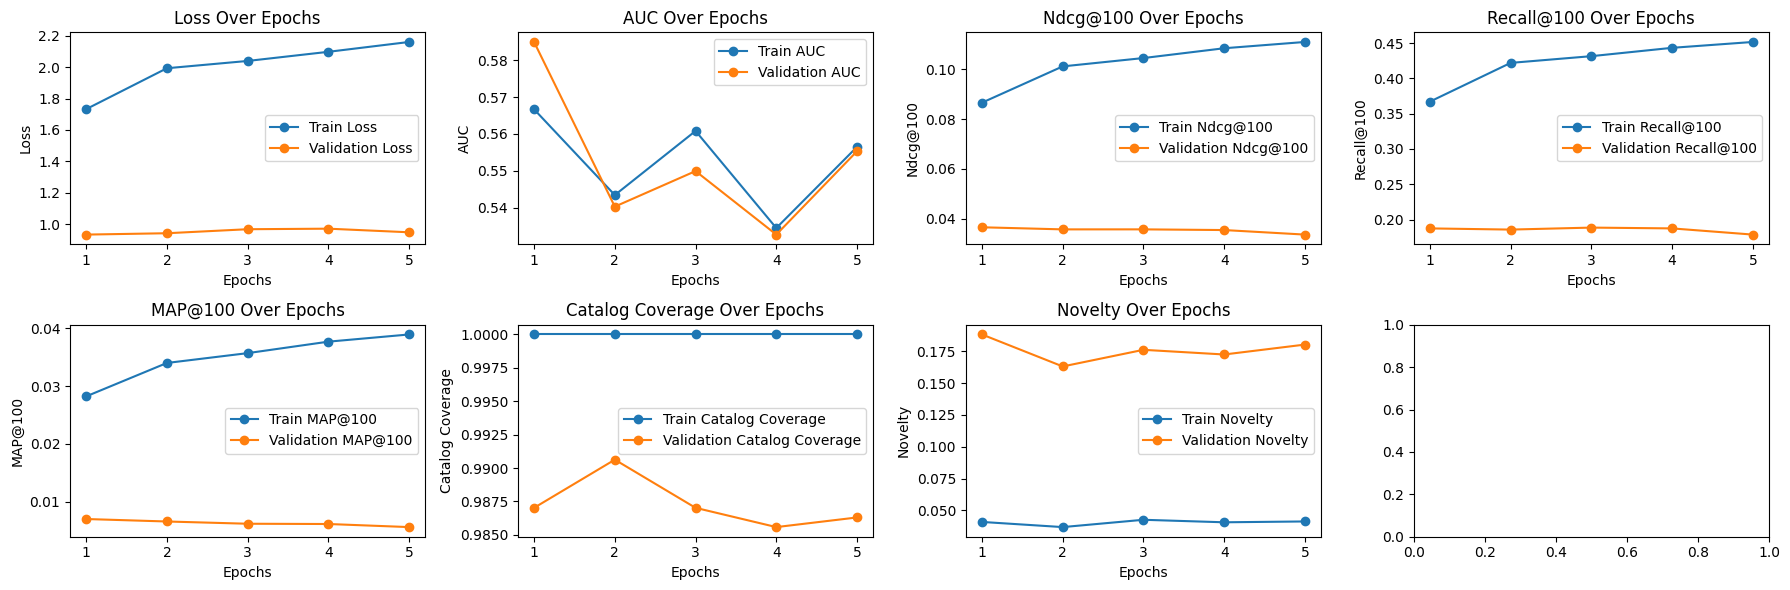

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


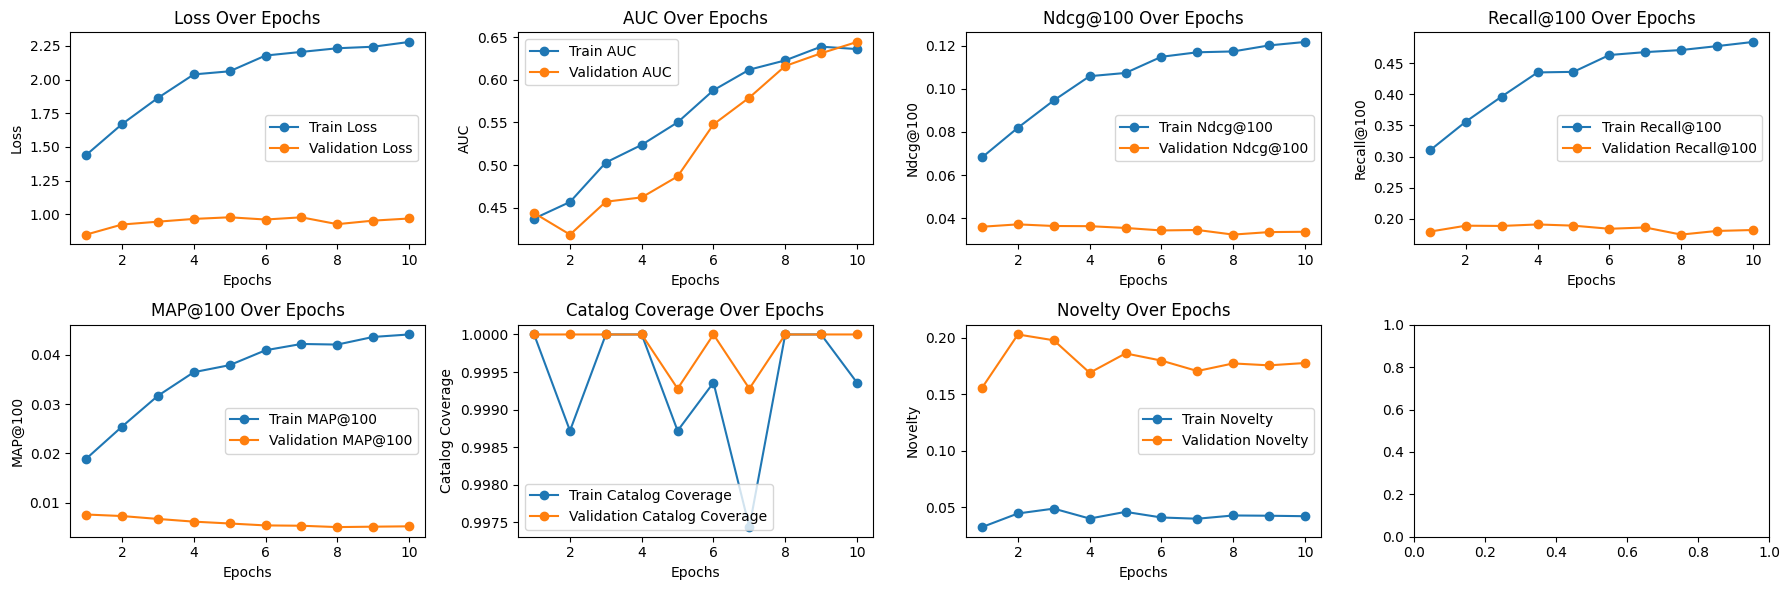

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


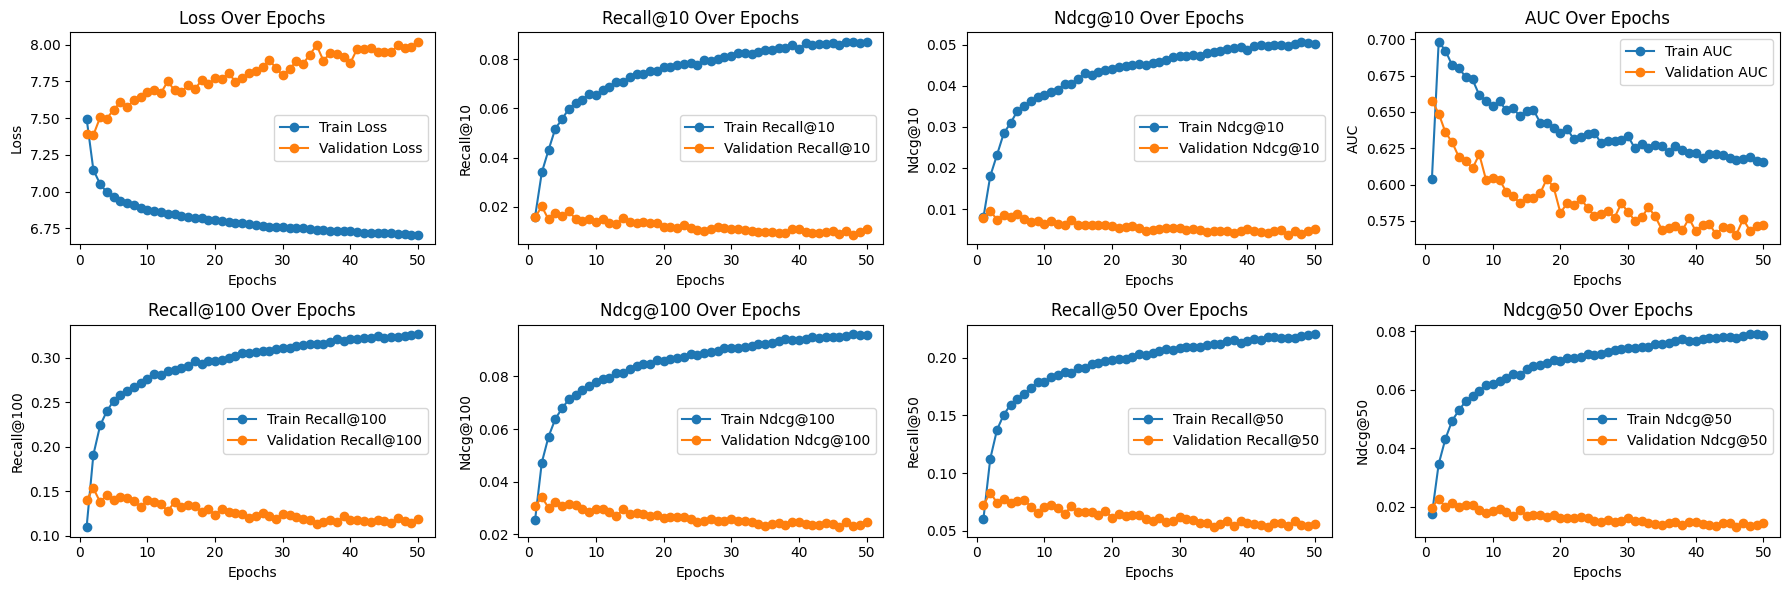

In [ ]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

# Analysis

### Collect cold candidate

In [59]:
data = test
data_df = test_df
model = models['v101']

In [69]:
# load the original data
synopsis_df = pd.read_parquet(os.path.join(DATA_DIR, 'movielens_100k_synopsis_raw.parquet')).rename({
    'movie_id':'movie_id_raw'
}, axis=1)
# synopsis_df.head()

In [81]:
data_df

,movie_id,movie_id_raw,user_id,gender,occupation,genres,rating,synopsis,title,cast
0,311,679,226,2,12,"[6, 3]",0,311,311,"[15, 33, 1315, 1312, 1316]"
1,311,679,170,1,1,"[6, 3]",0,311,311,"[15, 33, 1315, 1312, 1316]"
2,311,679,38,1,4,"[6, 3]",1,311,311,"[15, 33, 1315, 1312, 1316]"
3,311,679,106,2,2,"[6, 3]",0,311,311,"[15, 33, 1315, 1312, 1316]"
4,311,679,169,1,4,"[6, 3]",1,311,311,"[15, 33, 1315, 1312, 1316]"
...,...,...,...,...,...,...,...,...,...,...
14532,1403,992,26,1,1,"[2, 4]",1,1390,1389,"[430, 228, 4051, 260, 4072]"
14533,1616,1525,37,1,8,"[2, 5]",1,1572,1607,"[1569, 442, 167, 1206, 4699, 903]"
14534,1130,1615,143,2,11,"[17, 6, 3, 10]",1,1135,1126,"[3363, 3348, 3336, 3326, 3389, 3400, 3339]"
14535,1318,1138,143,2,11,"[2, 9, 1, 3]",1,1301,1340,"[3809, 2776, 3802, 3895]"


In [82]:
# cold movies
cold_movies = list(set(data_df['movie_id_raw'].unique()).difference(set(train_df['movie_id_raw'].unique())))
cold_movies_df = synopsis_df[synopsis_df['movie_id_raw'].isin(cold_movies)]
cold_movies_df

,movie_id_raw,title,synopsis,cast
597,1398,Anna (1996),Anna is a 1996 mystery thriller film about a y...,"Sally Kirkland, Paulina Porizkova, Robert Fiel..."
777,626,So Dear to My Heart (1949),"""So Dear to My Heart"" is a heartwarming family...","Bobby Driscoll, Beulah Bondi, Burl Ives"
856,1458,"Damsel in Distress, A (1937)",A Damsel in Distress (1937) is a romantic come...,"Fred Astaire, Joan Fontaine, George Burns, Gra..."
869,1447,Century (1993),Century is a mystery thriller film set in the ...,"Sylvester Stallone, Michelle Pfeiffer, Robert ..."
1140,1189,Prefontaine (1997),Prefontaine is a biographical sports drama fil...,"Jared Leto, Ed O'Neill, R. Lee Ermey, Breckin ..."
...,...,...,...,...
1656,1520,"Fear, The (1995)",The Fear (1995) is a thriller film directed by...,"Mark Wahlberg, Reese Witherspoon, William Pete..."
1662,600,Daniel Defoe's Robinson Crusoe (1996),Daniel Defoe's Robinson Crusoe (1996) is a fil...,"Pierce Brosnan, William Takaku, Polly Walker"
1665,1682,Scream of Stone (Schrei aus Stein) (1991),Scream of Stone (Schrei aus Stein) (1991) tell...,"Stefan Glowacz, Mathilda May, Susanne Lothar, ..."
1671,1674,Mamma Roma (1962),Mamma Roma is a 1962 Italian drama film direct...,"Anna Magnani, Ettore Garofolo, Franco Citti, S..."


In [102]:
from merlin.io import Dataset
# let's pick one cold movie for analysis
cold_movie_id = 1458
cold_movie_ds = Dataset(
    data_df[data_df['movie_id_raw'] == cold_movie_id],
    schema = data.schema
)
cold_movie_ds.head()

,movie_id,movie_id_raw,user_id,gender,occupation,genres,rating,synopsis,title,cast
14508,1636,1458,9,1,16,"[2, 5, 13]",1,1626,1544,"[1874, 1764, 3210, 4393]"


In [87]:
assert train_df[train_df['movie_id_raw'] == cold_movie_id].empty

### Generate dataset embedding space

In [95]:
from model_helper import get_candidates
from model_helper import batch_predict

In [96]:
def collect_embeddings(model, candidates, batch_size=512):
    candidate_id=Tags.ITEM_ID
    output_schema = model.schema.select_by_tag(candidate_id)

    return batch_predict(
            model.candidate_encoder,
            candidates,
            batch_size=batch_size,
            output_schema=output_schema,
            index=candidate_id,
            output_concat_func=np.concatenate,
    )

In [100]:
%%time
candidate_features = get_candidates(train, [Tags.ITEM, Tags.ITEM_ID])
train_embeddings = collect_embeddings(model, candidate_features)
train_embeddings.head()

Candidate set rows: 1561


CPU times: user 58.9 s, sys: 2.9 s, total: 1min 1s
Wall time: 1min 17s


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
movie_id,,,,,,,,,,,,,,,,,,,,,
337,-0.004439,-0.269566,-0.066219,0.153386,-0.129167,-0.191331,-0.065076,-0.105870,0.970532,-0.056495,...,0.145010,0.128386,0.067702,0.277694,3.225421,0.036757,0.224580,0.120815,-0.046743,-0.095964
77,-0.220160,-0.460105,0.049557,0.109430,-0.130928,-0.303938,0.049761,-0.079654,-0.793785,0.056044,...,-0.304601,-0.000286,-0.000553,0.360746,3.405063,-0.143335,0.879370,-0.115031,-0.170333,0.519094
5,-0.066230,-0.212405,0.028699,0.022943,-0.093566,-0.053190,-0.009539,0.018516,-0.356009,0.047950,...,-0.100356,0.084678,-0.000009,0.138799,2.002895,-0.070410,-0.251292,-0.078465,-0.011417,0.065946
614,0.096903,-0.680365,-0.032382,0.098803,-0.113268,-0.060731,-0.048837,-0.217143,-1.241157,-0.087437,...,-0.199225,0.160629,-0.301853,0.324090,4.383002,-0.083007,0.211726,0.385287,-0.282069,-0.715888
1184,0.013918,-2.427149,-0.085990,0.027074,0.053570,0.009237,-0.112070,-0.017847,0.645305,-0.232237,...,-0.799141,-0.057989,-0.205650,0.476036,5.269663,0.091306,0.599636,-0.250642,-0.146899,-0.728233


In [103]:
%%time
# convert cold movie to embeddings
cold_movie_embeddings = collect_embeddings(model, cold_movie_ds)
cold_movie_embeddings.head()

CPU times: user 55.3 s, sys: 3 s, total: 58.3 s
Wall time: 59.9 s


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
movie_id,,,,,,,,,,,,,,,,,,,,,
1636,0.015495,1.511249,-0.055724,0.035978,-0.024745,0.116934,-0.222299,0.265305,-1.52438,-0.181489,...,0.130312,0.016438,-0.09118,0.30754,1.949887,0.106512,1.721681,-0.095361,-0.151389,-0.058063


### Search Vector Space, find similar items

In [107]:
%%bash
pip install --extra-index-url=https://pypi.nvidia.com cuml-cu12

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.8/961.8 MB 790.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.2/503.2 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.6/81.6 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.2/198.2 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.4/582.4 kB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.17.9 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.24.3 which is incompatible.


In [108]:
from cuml.metrics.pairwise_distances import pairwise_distances

In [110]:
pairwise_distances(cold_movie_embeddings.to, train_embeddings, metric='cosine', dtype=np.float32)

ValueError: ignored

In [ ]:
`from sklearn.metrics.pairwise import cosine_similarity

# Suppose you have a target item's ID and its vector
target_item_id = 'your_target_item_id'
target_vector = df[df['item_id'] == target_item_id]['vector'].values[0]

# Calculate the cosine similarity between the target vector and all other item vectors
item_vectors = np.vstack(df['vector'].values)
similarities = cosine_similarity([target_vector], item_vectors)[0]

# Create a new DataFrame with item IDs and their similarity scores
similar_items_df = pd.DataFrame({'item_id': df['item_id'], 'similarity_score': similarities})

# Sort the DataFrame by similarity score in descending order to get most similar items first
similar_items_df = similar_items_df.sort_values(by='similarity_score', ascending=False)

# You can now access the most similar items and their similarity scores
print(similar_items_df.head())